In [1]:
"""
# Define pitch
F = [0,1,0] ; E_sharp = [0,1,0]
C = [1,0,1] ; B_sharp = [1,0,1] 
G = [0,-1,2]
D = [-1,0,3]
A = [0,1,4]
E = [1,0,5]  ; F_flat = [1,0,5]
B = [0,-1,6]  ; C_flat = [0,-1,6]
F_sharp = [-1,0,7] ; G_flat = [-1,0,7]
C_sharp = [0,1,8] ; D_flat = [0,1,8]
G_sharp = [1,0,9] ; A_flat = [1,0,9]
D_sharp = [0,-1,10] ; E_flat = [0,-1,10]
A_sharp = [-1,0,11] ; B_flat = [-1,0,11]
"""
print()

In [1]:
import librosa
import os, sys
import numpy as np
from pydub import AudioSegment
from pydub.utils import make_chunks
import warnings
import matplotlib.pyplot as plt
from collections import Counter
from librosa import display
warnings.filterwarnings('ignore')

pitch_ary = [[1,0,1], [0,1,8], [-1,0,3], [0,-1,10], [1,0,5], [0,1,0], [-1,0,7],\
                 [0,-1,2], [1,0,9], [0,1,4], [-1,0,11], [0,-1,6]]
pitch_ary = np.array(pitch_ary)

## get all clip 
def get_dirs(path):
    dirs = os.listdir(path)
    return dirs  # file list

c:\users\asus\appdata\local\programs\python\python35\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
def pitch_trans(seq):
    pitch_list = ['C','C#','D','D#(E-)','E','F','F#','G','G#','A','A#(B-)','B']
    return pitch_list[seq]

def pitch_to_ary(notes):
    pitch_ary = [[1,0,1], [0,1,8], [-1,0,3], [0,-1,10], [1,0,5], [0,1,0], [-1,0,7],\
                 [0,-1,2], [1,0,9], [0,1,4], [-1,0,11], [0,-1,6]]
    pitch_ary = np.array(pitch_ary)
    return pitch_ary[notes]
# plt.figure(figsize=(15, 5))
# plt.plot(times, o_env, label='Onset strength')
# plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
#             linestyle='--', label='Onsets')
# plt.axis('tight')

In [3]:
## count CE
def count_CE(notes_seq):
    c = Counter(notes_seq)
    Dab = 0
    sum_dp = 0
    for i in range(len(notes_seq)):
        pij = (pitch_to_ary(notes_seq[i]))
        dij = 1
        Dab = sum(c.values())
        sum_dp += (dij * pij)  
        CE = sum_dp/Dab   
    return CE

def get_key(CE, pitch_ary):
    key = []
    for i in range(len(pitch_ary)):
        key.append(abs(pitch_ary[i][0]-int(CE[0])) + abs(pitch_ary[i][1]-int(CE[1])) + \
                  abs(pitch_ary[i][2]-int(CE[2])))
    predict_key = pitch_trans(key.index(min(key)))
    return predict_key

In [41]:
## get all file name
sleeping_music = sorted(get_dirs('./music/sleeping'))
classic_music = sorted(get_dirs('./music/classic'))
pop_music = sorted(get_dirs('./music/pop'))

Wall time: 0 ns
Wall time: 0 ns


In [ ]:
%time
sleeping_key = []
for idx in range(len(sleeping_music)):
# for idx in range(1,2):
    y, sr = librosa.load('./music/sleeping/'+ sleeping_music[idx])
#     duration = librosa.core.get_duration(y=y, sr=22050, n_fft=2048, hop_length=512)
    for i in range(int(1800/4)):
        y1, sr = librosa.load('./music/sleeping/'+ sleeping_music[idx],offset=4*i, \
                              duration = 4)
         ## onset detection
        onset_frames = librosa.onset.onset_detect(y=y1, sr=sr)
        o_env = librosa.onset.onset_strength(y1, sr=sr)
        times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

        ## pitch detection
        b = librosa.feature.chroma_stft(y=y1, sr=sr, n_fft=1024, hop_length=512)

        temp =[]; pitch = []
        for i in range(len(onset_frames)): 
            temp.append(np.argsort(b[:,onset_frames[i]])[-1])  
        for i in range(len(temp)):
            pitch.append(pitch_trans(temp[i]))    

        ## count CE
        CE = (count_CE(temp))
        sleeping_key.append(get_key(CE, pitch_ary))

Wall time: 0 ns


In [18]:
len(sleeping_key)

1800

In [28]:
def n_gram(key_list, ngram):
    k_list = [[word for word in line.split(",")] for line in key_list]
    flattened = [val for sublist in k_list for val in sublist]
    ngram_key = []
    for i in range(int(len(flattened)/ngram)):
        ngram_key.append(flattened[ngram*i : ngram*(i+1)])
    count_ary = [[x,ngram_key.count(x)] for x in (ngram_key)]
    unique = []
    for item in count_ary:
        if item not in unique:
            unique.append(item)
    unique = sorted(unique, key=lambda x:x[1], reverse = True)
    return unique

In [33]:
n_gram(sleeping_key, 5)

[[['E', 'E', 'E', 'E', 'E'], 6],
 [['E', 'E', 'E', 'E', 'A'], 4],
 [['A', 'A', 'A', 'A', 'A'], 4],
 [['E', 'A', 'E', 'E', 'E'], 3],
 [['E', 'E', 'E', 'A', 'E'], 3],
 [['E', 'A', 'B', 'E', 'E'], 3],
 [['G', 'C', 'C', 'C', 'C'], 3],
 [['D', 'C', 'C', 'G', 'C'], 3],
 [['C', 'C', 'C', 'G', 'D'], 3],
 [['D', 'A', 'D', 'D', 'D'], 3],
 [['G', 'G', 'G', 'C', 'C'], 3],
 [['E', 'E', 'B', 'E', 'E'], 2],
 [['E', 'E', 'E', 'B', 'A'], 2],
 [['E', 'E', 'B', 'B', 'B'], 2],
 [['E', 'B', 'E', 'E', 'A'], 2],
 [['E', 'E', 'E', 'E', 'B'], 2],
 [['E', 'E', 'E', 'A', 'B'], 2],
 [['E', 'E', 'A', 'E', 'E'], 2],
 [['C', 'C', 'C', 'C', 'F'], 2],
 [['C', 'C', 'C', 'C', 'G'], 2],
 [['A', 'C', 'C', 'G', 'C'], 2],
 [['F', 'F', 'C', 'C', 'C'], 2],
 [['G', 'G', 'C', 'C', 'C'], 2],
 [['C', 'C', 'C', 'F', 'G'], 2],
 [['C', 'C', 'C', 'C', 'D'], 2],
 [['C', 'C', 'F', 'C', 'C'], 2],
 [['D', 'G', 'G', 'C', 'G'], 2],
 [['G', 'G', 'G', 'G', 'D'], 2],
 [['G', 'C', 'C', 'G', 'C'], 2],
 [['A', 'A', 'E', 'E', 'B'], 2],
 [['D', 'A

In [ ]:
# o_env = librosa.onset.onset_strength(y1, sr=sr)
# times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
# onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

# import matplotlib.pyplot as plt
# D = np.abs(librosa.stft(y1))
# plt.figure()
# ax1 = plt.subplot(2, 1, 1)
# librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
#                           x_axis='time', y_axis='log')
# plt.title('Power spectrogram')
# plt.subplot(2, 1, 2, sharex=ax1)
# plt.plot(times, o_env, label='Onset strength')
# plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
#             linestyle='--', label='Onsets')
# plt.axis('tight')
# plt.legend(frameon=True, fram1ealpha=0.75)

In [35]:
c = Counter(temp)
Dab = 0
sum_dp = 0
for i in range(len(temp)):
    pij = ((temp[i]))
    dij = 1
    Dab = sum(c.values())
    sum_dp += (dij * pij)  
    CE = sum_dp/Dab   

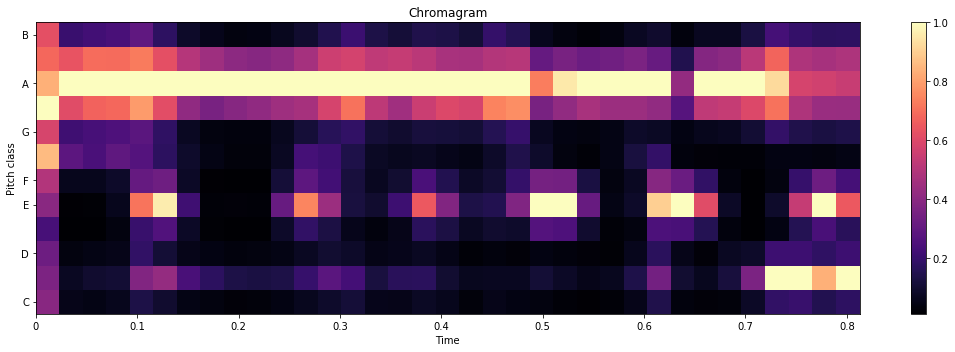

In [37]:
# for i in range(2):
# y,sr = librosa.load('./test/soda/'+ clip_list2[i])    
b = librosa.feature.chroma_stft(y=y1, sr=sr,  n_fft=1024, hop_length=512)
plt.figure(figsize=(15, 5))
librosa.display.specshow(b, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

In [ ]:
# ## split audio
# def chunk_wav(file, chunk_ms,folder, title):
#     chunks = make_chunks(file, chunk_ms)
#     # Export all of the individual chunks as wav files
#     for i, chunk in enumerate(chunks):
#         chunk_name = os.path.join("./test", folder,"{0}_chunk{1}.wav".format(title, i))
#         librosa.output.write_wav(chunk_name, chunk, sr)
